In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import math
import pickle

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from scipy.optimize import optimize
from collections import defaultdict
from itertools import izip_longest
from functools import partial

In [3]:
def sphere(*args):
    k = 0
    for i in args: k += i**2
    return k
logSpace = np.logspace(-5, 2, 35)
logNorm = LogNorm()

def rastrigin(*args):
    A = 10
    return A + sum([(i**2 - A * np.cos(2 * math.pi * i)) for i in args])

def styblinskiTang(*args):
    return sum([(i**4 - 16 * i**2 + 5 * i) for i in args])
stSpace = np.linspace(-200, 100, 35)
stNorm = None

# f = rastrigin
# name = "rastrigin"
# fspace = logSpace
# fnorm = logNorm


### Initialize Parameters for Drawing Plot

In [4]:
# x_lims formatted as [xmin, xmax, xstep] as a list
def get_mesh_for_plot(f, x_lims, y_lims):
    xmin, xmax, xstep = tuple(x_lims)
    ymin, ymax, ystep = tuple(y_lims)
    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = f(x, y)
    return x, y, z


### 3-D Plot Function

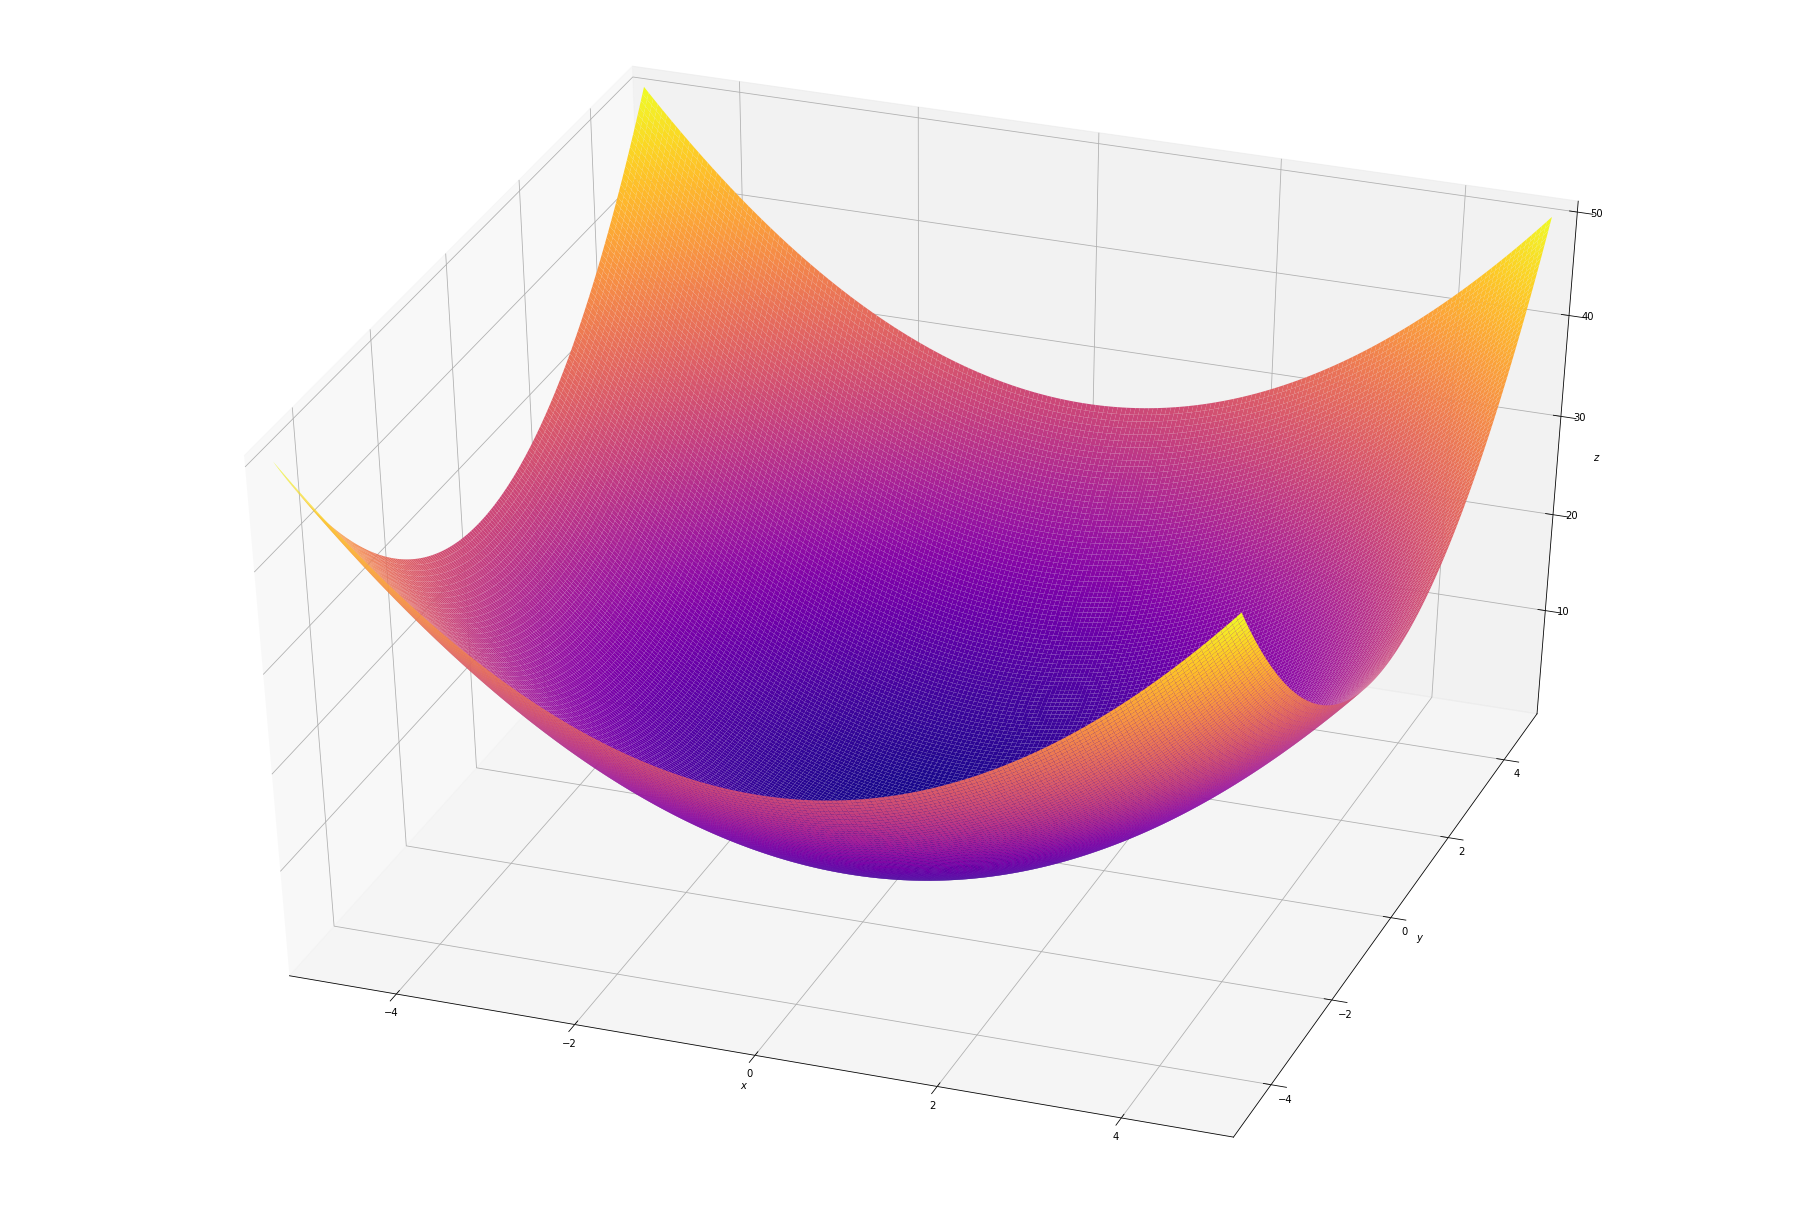

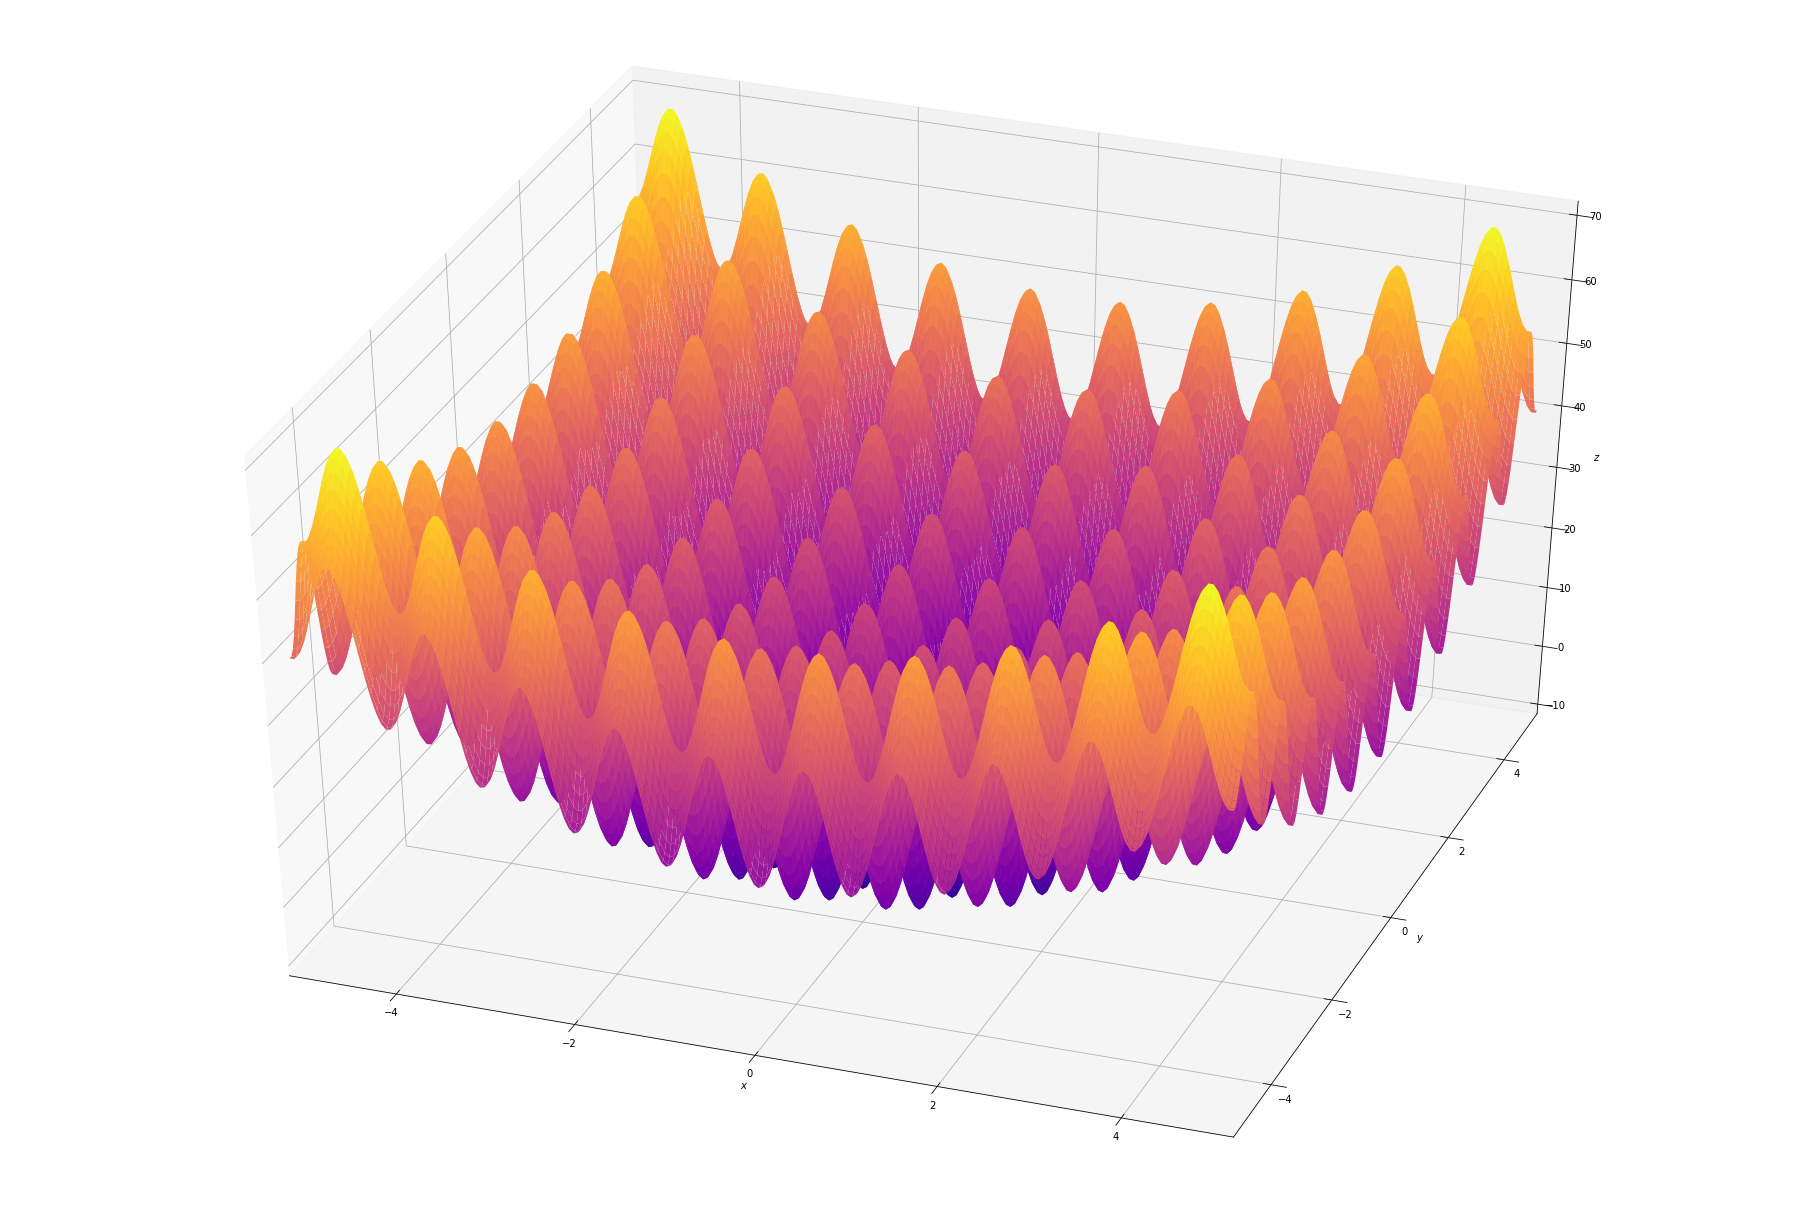

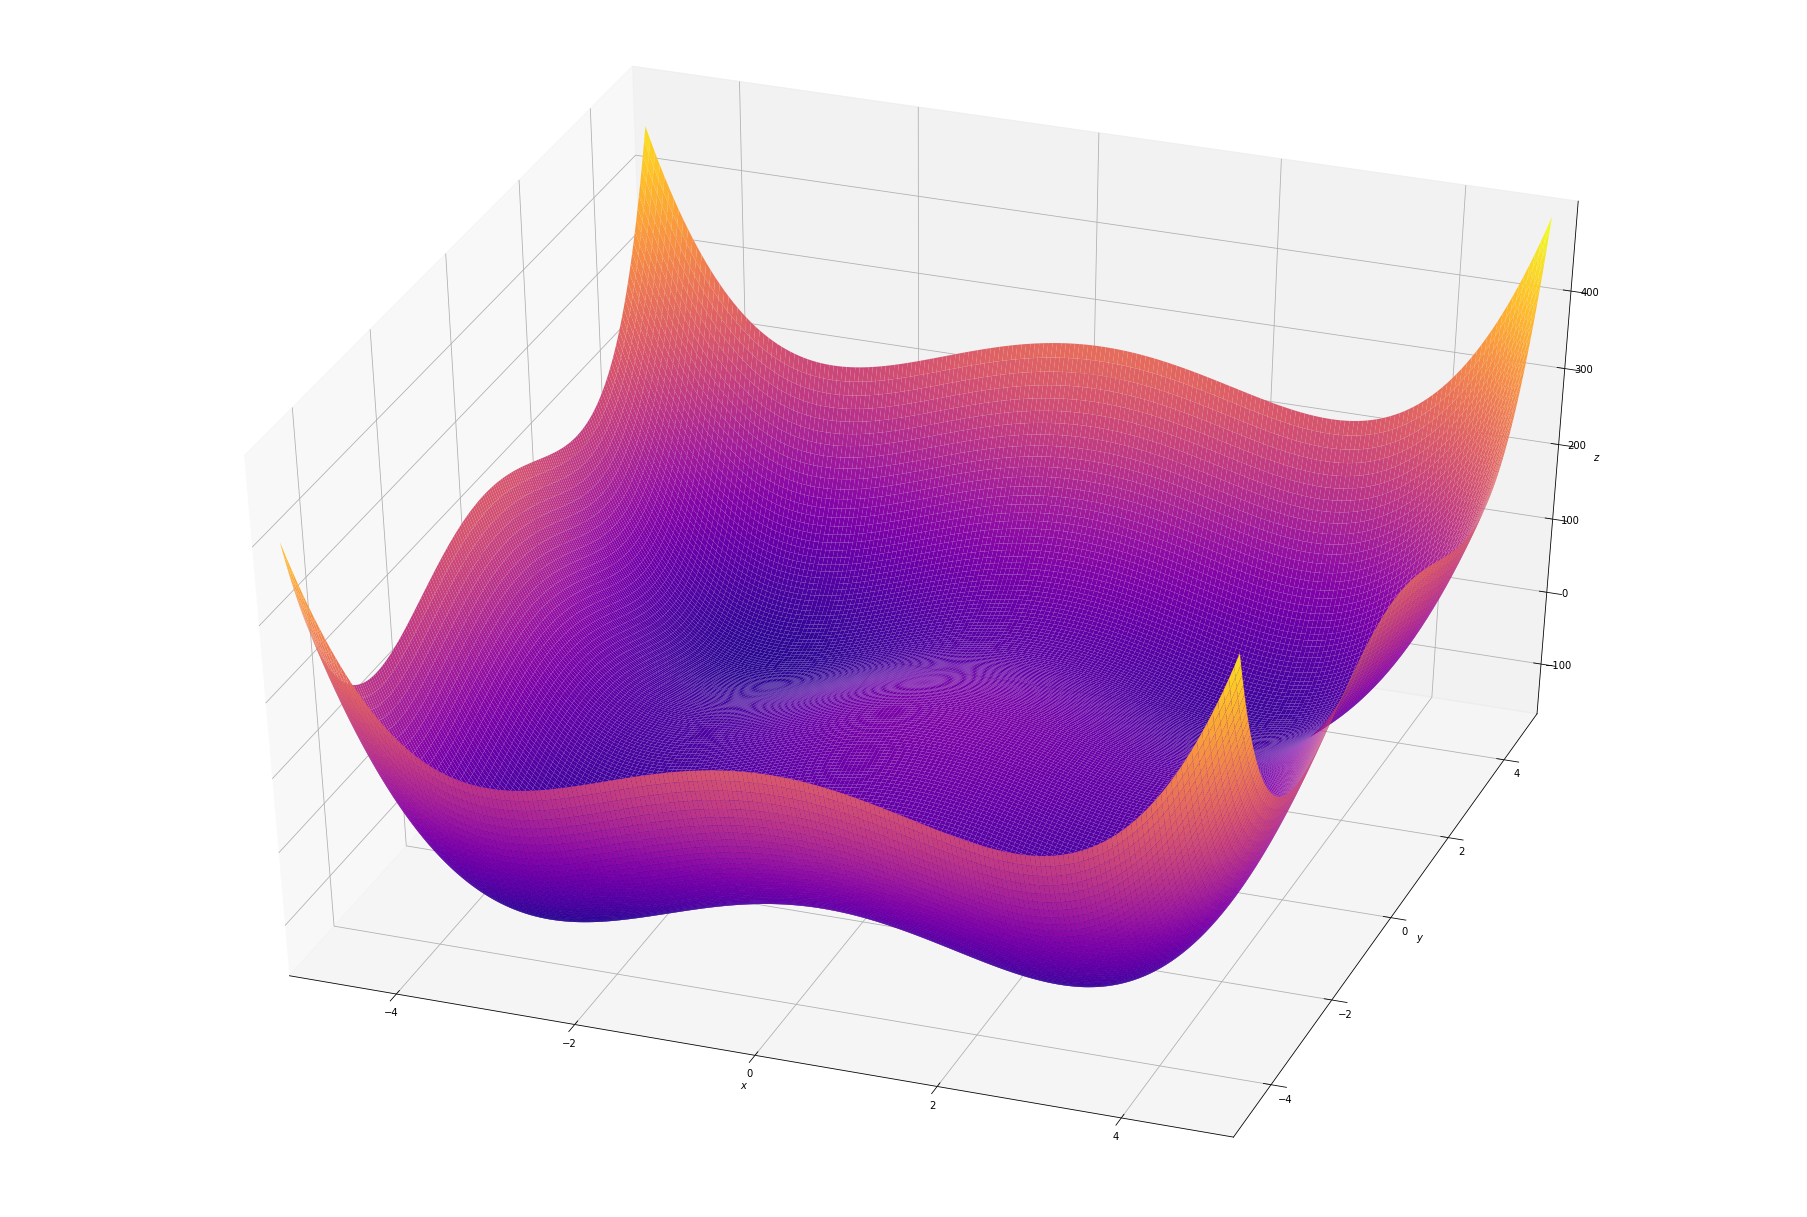

In [6]:
def three_dimentional_plot(f, x_lims, y_lims):
    x, y, z = get_mesh_for_plot(f, x_lims, y_lims)
    xmin, xmax, xstep = tuple(x_lims)
    ymin, ymax, ystep = tuple(y_lims)
    
    fig = plt.figure(figsize=(32, 22))
    ax = plt.axes(projection='3d', elev=40, azim=-70)

    ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=plt.cm.plasma, linewidth=1, antialiased=True)
    # ax.plot(*minima_, f(*minima), 'r*', markersize=20, color="r")

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show()

three_dimentional_plot(sphere, [-5, 5, 0.05], [-5, 5, 0.05])
three_dimentional_plot(rastrigin, [-5, 5, 0.05], [-5, 5, 0.05])
three_dimentional_plot(styblinskiTang, [-5, 5, 0.05], [-5, 5, 0.05])

### Plot Contour Map

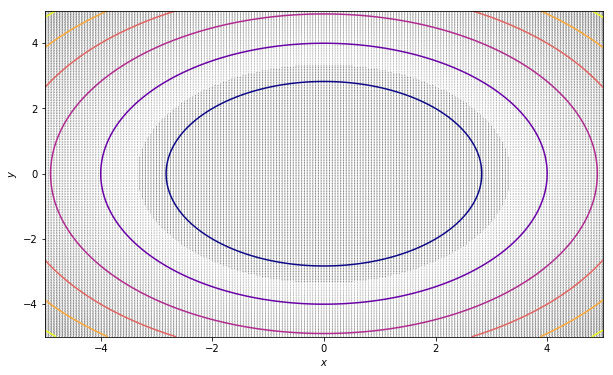

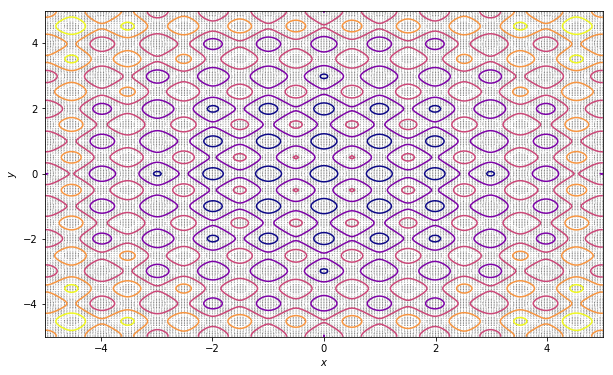

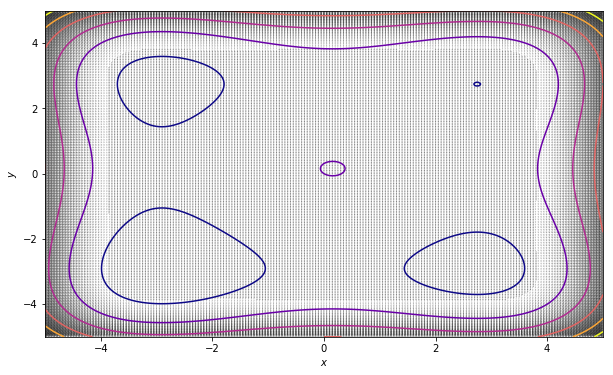

In [7]:
def contour_plot(f, x_lims, y_lims):
    x, y, z = get_mesh_for_plot(f, x_lims, y_lims)
    xmin, xmax, xstep = tuple(x_lims)
    ymin, ymax, ystep = tuple(y_lims)
    
    dz_dx = elementwise_grad(f, argnum=0)(x, y)
    dz_dy = elementwise_grad(f, argnum=1)(x, y)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, cmap=plt.cm.plasma) # took out levels=fspace, norm=fnorm, 
    ax.quiver(x, y, x - dz_dx, y - dz_dy, alpha=.5)
    #ax.plot(*minima_, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show()
    
contour_plot(sphere, [-5, 5, 0.05], [-5, 5, 0.05])
contour_plot(rastrigin, [-5, 5, 0.05], [-5, 5, 0.05])
contour_plot(styblinskiTang, [-5, 5, 0.05], [-5, 5, 0.05])

### Optimize

In [75]:
# func = value_and_grad(lambda args: f(*args))
# x0 = np.array([3., 4.])
# res = minimize(func, x0=x0, method='Newton-CG', jac=True, tol=1e-20)
# print res

# def make_minimize_cb(path=[]):  
#     def minimize_cb(xk):
#         # note that we make a deep copy of xk
#         path.append(np.copy(xk))
#     return minimize_cb

# path_ = [x0]
# minimize(func, x0=x0, method='Newton-CG',
#                jac=True, tol=1e-20, callback=make_minimize_cb(path_))
# path = np.array(path_).T
# path.shape
# print path

In [19]:
def sphere2(x):
    return sum([i**2 for i in x])

def rastrigin2(x):
    A = 10
    return A + sum([(i**2 - A * np.cos(2 * math.pi * i)) for i in x])

def styblinskiTang2(x):
    return sum([(i**4 - 16 * i**2 + 5 * i) for i in x])

'''
Optimizer_test class written by Pyokyeong Son
'''
class Optimizer:
    
    def __init__(self, f, eta, grad_step = 0.1):
        self.f = f
        self.eta = eta
        self.grad_step = grad_step
    
    def gradient_descent(self, param, count):
        path = [param]
        for i in range(count):
            param = self.update(param, self.f)
            path.append(param)

        path = np.array(path).T
        return path
    
    def gd_momentum(self, param, count, momentum=0.9):
        path = [param]
        update_vector = 0
        for i in range(count):
            (param, update_vector) = self.update_momentum(param, self.f, momentum, update_vector)
            path.append(param)

        path = np.array(path).T
        return path
    
    def gd_acceleration(self, param, count, momentum=0.9):
        path = [param]
        update_vector = 0
        for i in range(count):
            (param, update_vector) = self.update_accel(param, self.f, momentum, update_vector)
            path.append(param)

        path = np.array(path).T
        return path
    
    def update(self, params, f):

        delta_params = self.eta * optimize.approx_fprime(params, f, self.grad_step)
        #print "gradient: {0}".format(delta_params)
        params = [p - dp for p, dp in zip(params, delta_params)]

        return params

    def update_momentum(self, params, f, momentum, prev_update_vector):

        update_vector = momentum * prev_update_vector + self.eta * optimize.approx_fprime(params, f, self.grad_step)
        #print "gradient: {0}".format(optimize.approx_fprime(params, f, self.eta))
        params = [p - dp for p, dp in zip(params, update_vector)]

        return (params, update_vector)
    
    def update_accel(self, params, f, momentum, prev_update_vector):

        update_vector = momentum * prev_update_vector + self.eta * optimize.approx_fprime(params - prev_update_vector, f, self.grad_step)
        #print "gradient: {0}".format(optimize.approx_fprime(params, f, self.eta))
        params = [p - dp for p, dp in zip(params, update_vector)]

        return (params, update_vector)

def optimization_plot(f, x_lims, y_lims, path):
    x, y, z = get_mesh_for_plot(f, x_lims, y_lims)
    xmin, xmax, xstep = tuple(x_lims)
    ymin, ymax, ystep = tuple(y_lims)
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, levels=stSpace, norm=stNorm, cmap=plt.cm.plasma) # took out levels=fspace, norm=fnorm, 
    ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k', width=0.005)
    #ax.plot(minima_, 'r*', markersize=10)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show()
    
def animate_plot(f, x_lims, y_lims, path):
    x, y, z = get_mesh_for_plot(f, x_lims, y_lims)
    xmin, xmax, xstep = tuple(x_lims)
    ymin, ymax, ystep = tuple(y_lims)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, levels=stSpace, norm=stNorm, cmap=plt.cm.plasma) # took out levels=fspace, norm=fnorm, 
    # ax.plot(minima_, 'r*', markersize=18)

    line, = ax.plot([], [], 'b', label='Trajectory of Theta', lw=2)
    point, = ax.plot([], [], 'bo')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    ax.legend(loc='upper left')

    def init():
        line.set_data([], [])
        point.set_data([], [])
        return line, point

    def animate(i):
        line.set_data(*path[::,:i]) # comment out to not show the trajectory
        point.set_data(*path[::,i-1:i])
        return line, point

    return animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=path.shape[1], interval=100, 
                                   repeat_delay=5, blit=True)

def calc_cost(path):
    costs = []
    path = np.array(path).T
    for x in path:
        costs.append(sum([(i - 2.9)**2 for i in x]))
    return costs

## Complete Contour Path and Animation Here

final opt: 2.69331873072,2.69331873072


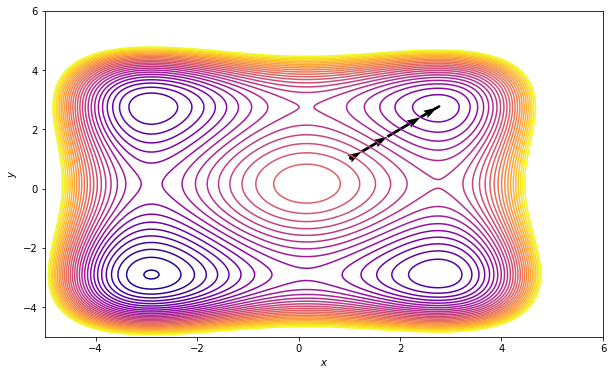

In [33]:
opt = Optimizer(styblinskiTang2, 0.01)
path = opt.gd_acceleration(np.array([1., 1.]), 10)
#path = opt.gradient_descent(np.array([5., 5.]), 10)
print "final opt: {0},{1}".format(path[0][-1],path[1][-1])

x_lim = [-5, 6, 0.05]
y_lim = [-5, 6, 0.05]

optimization_plot(styblinskiTang, x_lim, y_lim, path)

#anim = animate_plot(styblinskiTang, x_lim, y_lim, path)
#HTML(anim.to_html5_video())

## Normal Gradient Descent, Learning Rate 0.01

### Sphere

final opt: 2.67944582464,2.67944582464


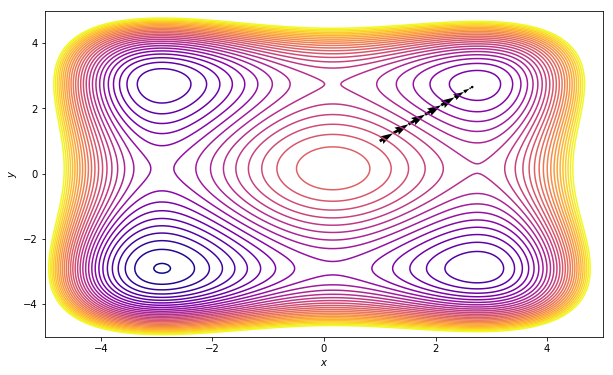

In [52]:
opt_sphere = Optimizer(styblinskiTang2, 0.01)
path_sphere = opt_sphere.gradient_descent(np.ones(3), 9)
print "final opt: {0},{1}".format(path_sphere[0][-1],path_sphere[1][-1])

x_lim = [-5, 5, 0.05]
y_lim = [-5, 5, 0.05]

optimization_plot(styblinskiTang, x_lim, y_lim, path_sphere)

#anim = animate_plot(styblinskiTang, x_lim, y_lim, path_sphere)
#HTML(anim.to_html5_video())

cost_sphere = calc_cost(path_sphere)

In [53]:
opt_sphere = Optimizer(styblinskiTang2, 0.01)
path_sphere4 = opt_sphere.gradient_descent(np.ones(4), 9)
cost_sphere4 = calc_cost(path_sphere4)

path_sphere5 = opt_sphere.gradient_descent(np.ones(5), 9)
cost_sphere5 = calc_cost(path_sphere5)

path_sphere6 = opt_sphere.gradient_descent(np.ones(6), 9)
cost_sphere6 = calc_cost(path_sphere6)

path_sphere100 = opt_sphere.gradient_descent(np.ones(100), 9)
cost_sphere100 = calc_cost(path_sphere100)

print len(cost_sphere)

10


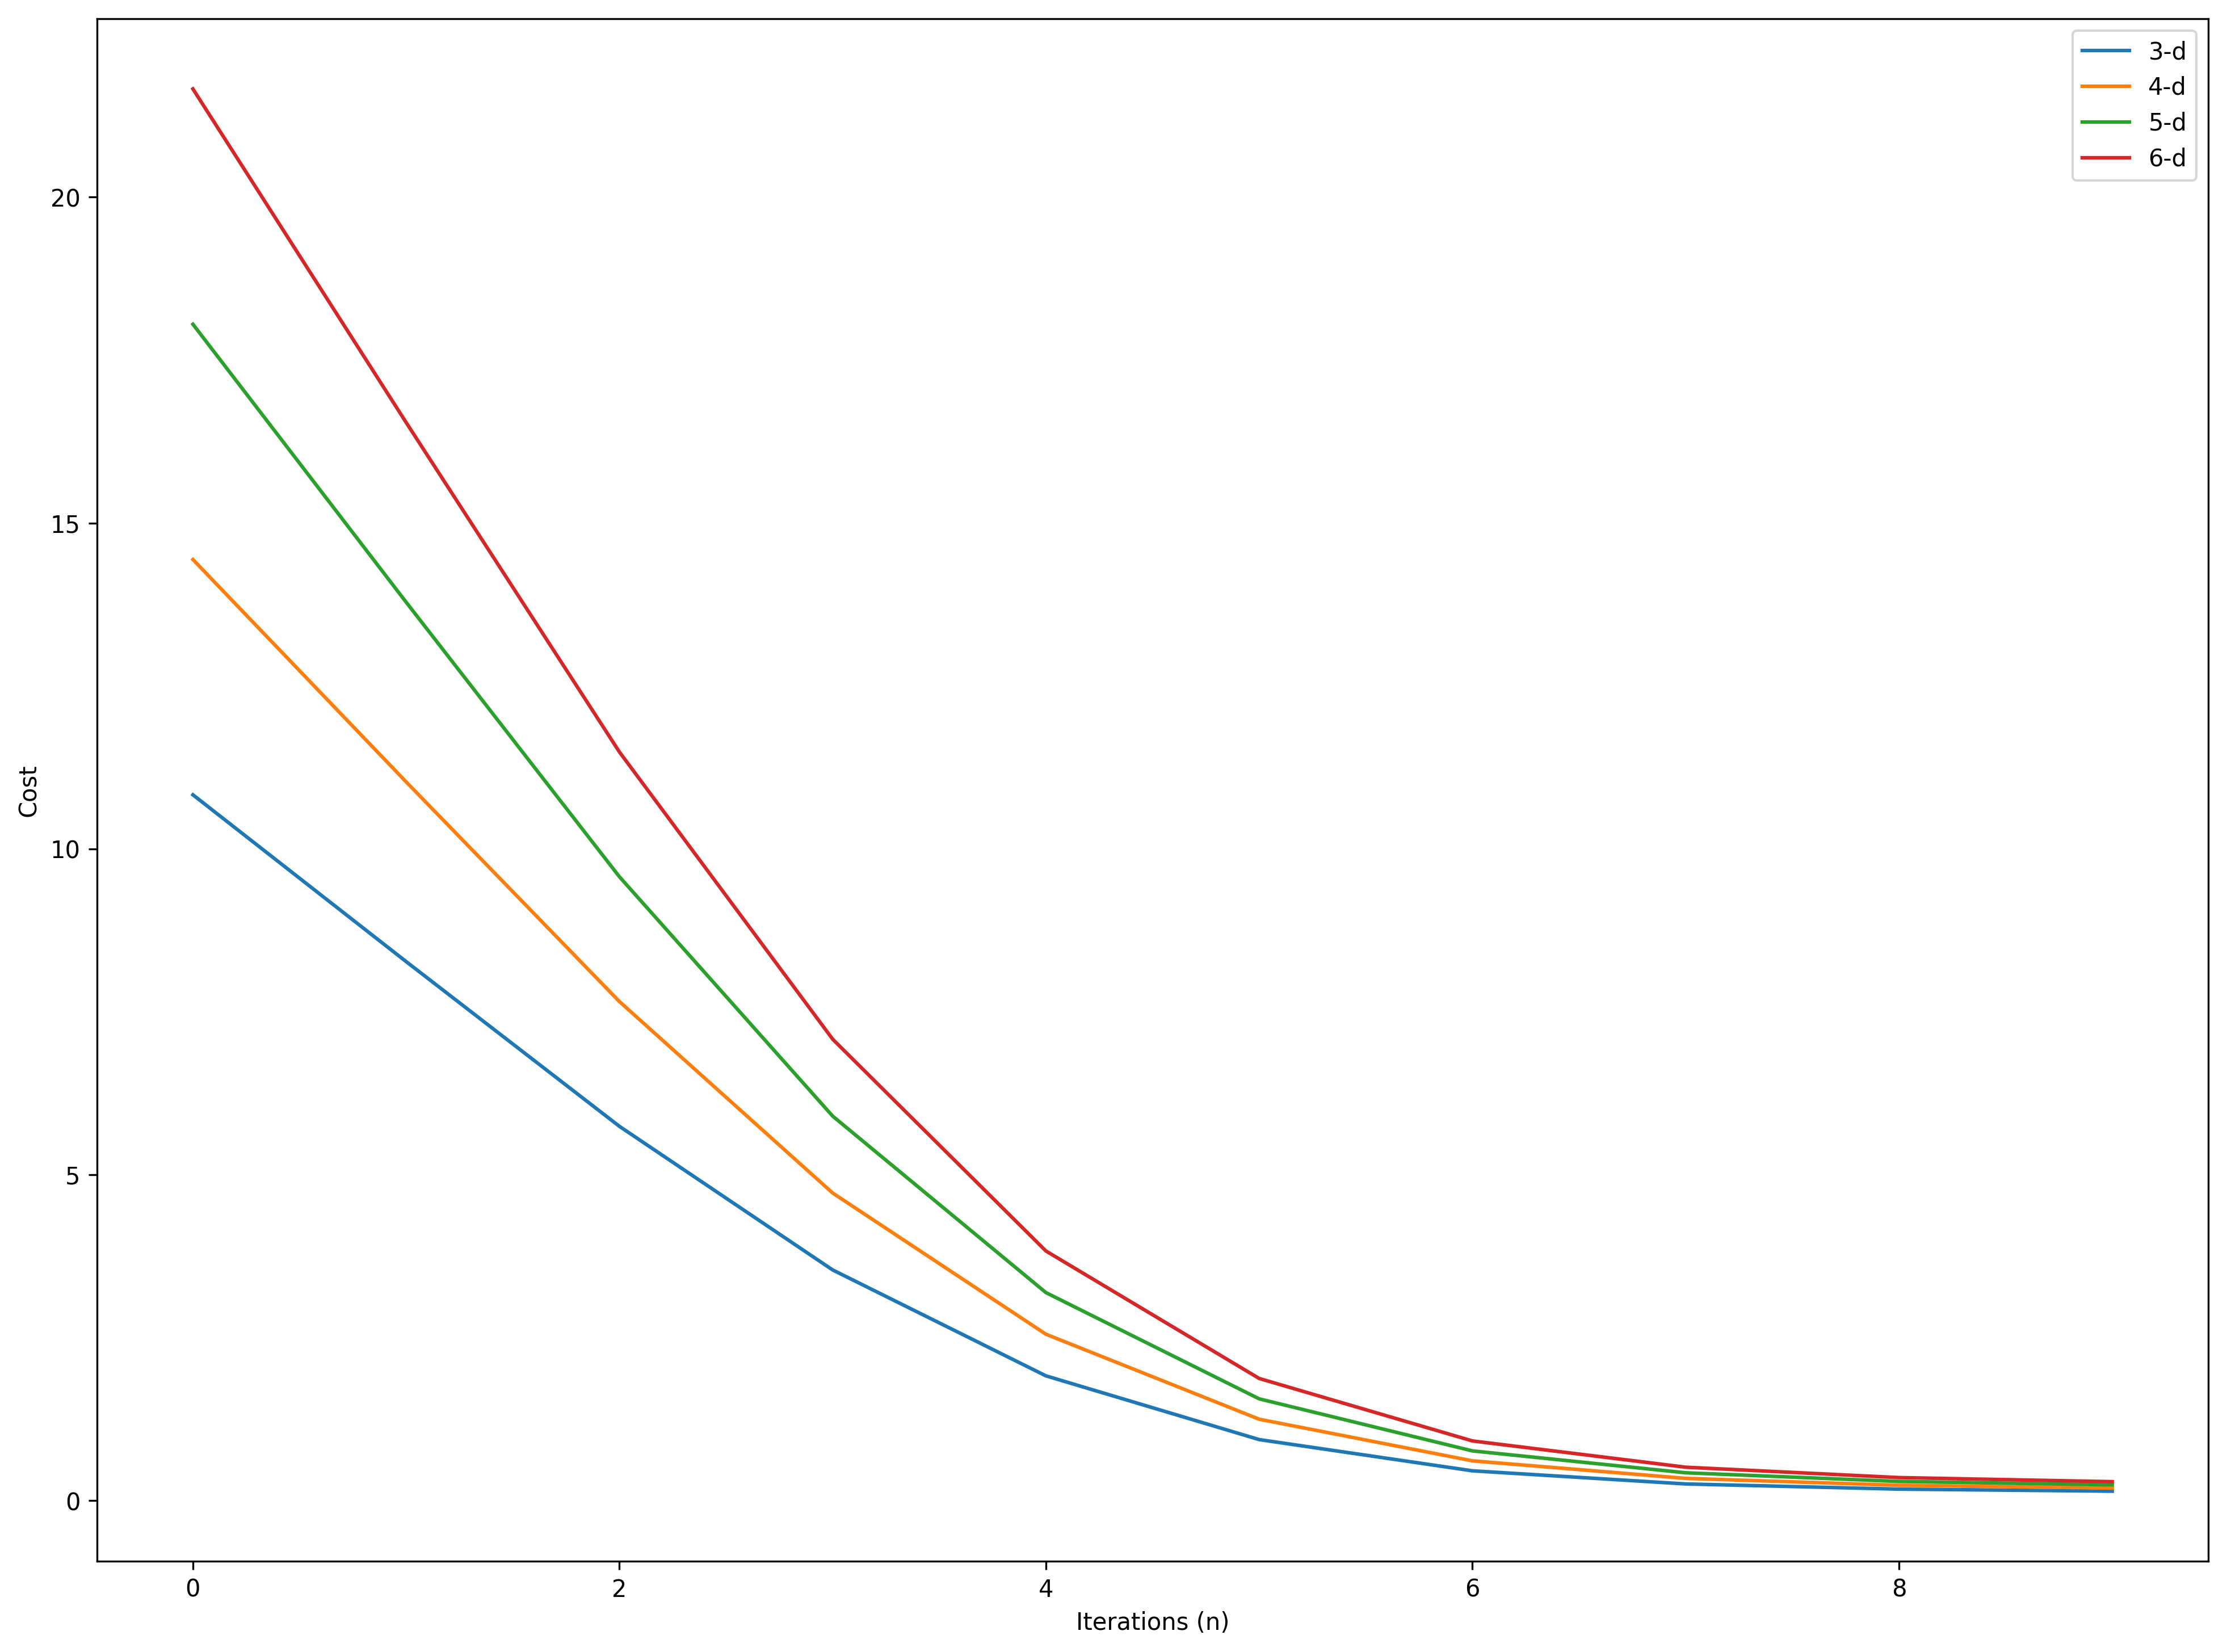

In [54]:
plt.figure(figsize=(16,12), dpi=300)
plt.plot(range(10), cost_sphere, label='3-d')
plt.plot(range(10), cost_sphere4, label='4-d')
plt.plot(range(10), cost_sphere5, label='5-d')
plt.plot(range(10), cost_sphere6, label='6-d')
#plt.plot(range(10), cost_sphere100, label='100-d')

plt.xlabel("Iterations (n)")
plt.ylabel("Cost")
plt.legend()

### Styblinki-Tang

final opt: 2.69633350189,2.69633350189


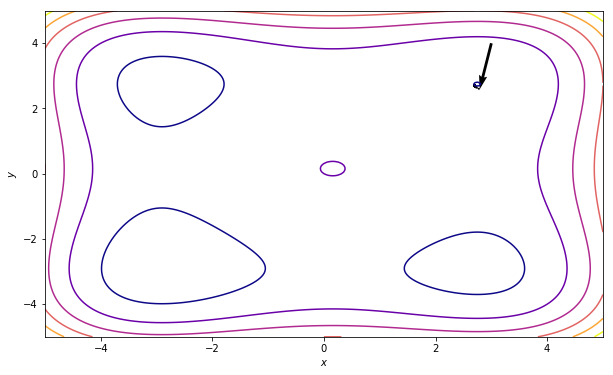

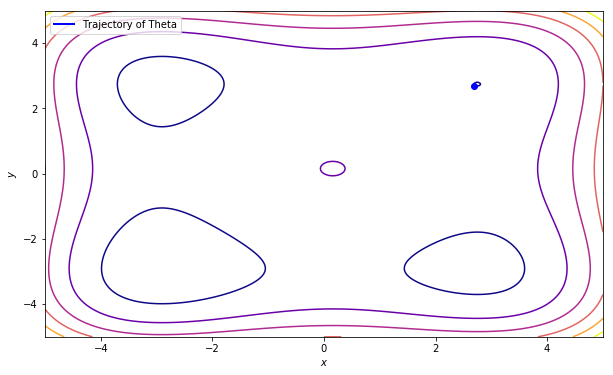

In [47]:
opt_st = Optimizer(styblinskiTang2, 0.01)
path_st = opt_st.gradient_descent(np.array([3., 4.]), 50)

print "final opt: {0},{1}".format(path_st[0][-1],path_st[1][-1])

optimization_plot(styblinskiTang, x_lim, y_lim, path_st)

anim_st = animate_plot(styblinskiTang, x_lim, y_lim, path_st)
HTML(anim_st.to_html5_video())

### Rastrigin

final opt: 3.04099871617,4.19012745087


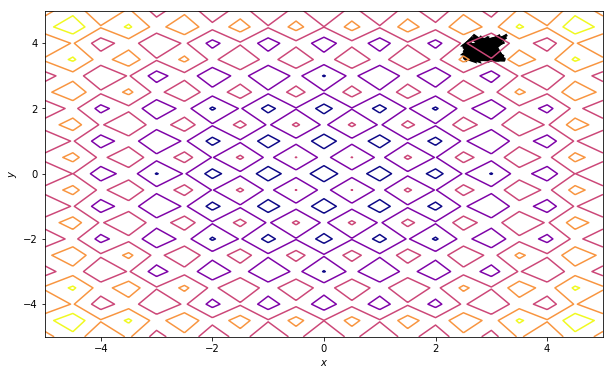

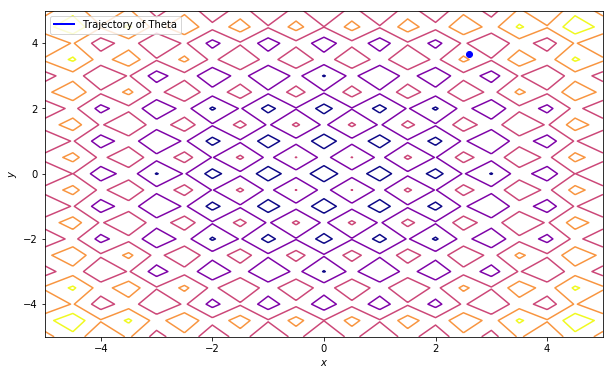

In [45]:
opt_r = Optimizer(rastrigin2, 0.01)
path_r = opt_r.gradient_descent(np.array([3., 4.]), 50)

print "final opt: {0},{1}".format(path_r[0][-1],path_r[1][-1])

optimization_plot(rastrigin, x_lim, y_lim, path_r)

anim_r = animate_plot(rastrigin, x_lim, y_lim, path_r)
HTML(anim_r.to_html5_video())